# Heavy rainfall worfklow - Preprocess
[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/CLIMAAX/HEAVY_RAINFALL/main?labpath=HEAVY_RAINFALL_preprocess.ipynb)

The data provided for the visualization workflow of flashfloods has been preprocessed by CRAHI-UPC. The steps followed to compute the necessary indicators that afterwards are used for the risk assessment are describe in this workflow.

## Hazard assessment methodology <a id="methodology"></a>
High intensity rainfall is ...(brief description).

The goal is to study the evolution and behaviour of annual maxima precipitation for different durations in order to provide the expected intensities for different return periods, so climate projections are necessary to assess future scenarios.

In this workflow, EURO-CORDEX climate projections for _precipitation flux_ at a 12km spatial resoltion are used and are available from the [Climate Data Store](https://cds.climate.copernicus.eu/cdsapp#!/dataset/projections-cordex-domains-single-levels?tab=overview) (CDS) portal. 

## Preparation work
In this notebook we will use some useful Python libraries:
* [cdsapi](https://cds.climate.copernicus.eu/api-how-to) - A library to request data from the datasets listed in the CDS catalogue.
* [numpy](https://numpy.org/doc/stable/) - A powerful library for numerical computations in Python, widely used for array operations and mathematical functions.
* [xarray](https://docs.xarray.dev/en/stable/) - Introduces labels in the form of dimensions, coordinates and attributes on top of raw NumPy-like arrays for a more intuitive experience.
* [rioxarray](https://corteva.github.io/rioxarray/stable/) - An extension of the xarray library that simplifies working with geospatial raster data.
* [scipy](https://docs.scipy.org/doc/scipy/) - Provides algorithms for optimization, statistics and many other classes of problems.
* [matplotlib](https://matplotlib.org/stable/) -  A versatile plotting library in Python, commonly used for creating static, animated, and interactive visualizations.

### Load libraries

In [1]:
# Libraries to download data and manage files
import os
import cdsapi
import zipfile

# Libraries for numerical computations, array manipulation and statistics.
import numpy as np
import xarray as xr
import scipy.stats as sst

# Libraries to handle geospatial data
import rioxarray as rio

# Libraries to plot maps, charts and tables
import matplotlib.pyplot as plt
from matplotlib.colors import from_levels_and_colors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
import plotly.express as px

# Choosing the matplotlib backend
%matplotlib inline

### Setting your directory

In [2]:
# Define the directory for the heavy workflow preprocess
workflow_dir = 'heavy_rainfall_workflow'

# Define directories for data and results within the previously defined workflow directory
data_dir = os.path.join(workflow_dir, 'data')
results_dir = os.path.join(workflow_dir, 'results')

# Check if the workflow directory exists, if not, create it along with subdirectories for data and results
if not os.path.exists(workflow_dir):
    os.makedirs(workflow_dir)
    os.makedirs(data_dir)
    os.makedirs(results_dir)


### Download data
It is possible to download the EURO-CORDEX data using the CDS API. Learn how to use it [here](https://cds.climate.copernicus.eu/api-how-to).

For this example, we will download 30 years of EURO-CORDEX precipitation data in a 3h temporal resolution for a particular pair of GCM and RCM and for a specific RCP.

:::{note}
It is possible to choose another pair of models or scenario. Feel free to explore the available data for [CORDEX](https://cds.climate.copernicus.eu/cdsapp#!/dataset/projections-cordex-domains-single-levels?tab=form).
:::

In [ ]:
# Change the KEY to your own
URL = "https://cds.climate.copernicus.eu/api/v2"
KEY = "1234"

# Define zip file's absolute path
zip_path = os.path.join(data_dir, 'cordex_pr_3h_2041_2070_rcp85.zip')

c = cdsapi.Client(url=URL, key=KEY)
c.retrieve(
        'projections-cordex-domains-single-levels',
        {
            'format': 'zip',
            'domain': 'europe',
            'experiment': 'rcp_8_5',
            'horizontal_resolution': '0_11_degree_x_0_11_degree',
            'temporal_resolution': '3_hours',
            'variable': 'mean_precipitation_flux',
            'gcm_model': 'ichec_ec_earth',
            'rcm_model': 'knmi_racmo22e',
            'ensemble_member': 'r1i1p1',
            'start_year': ['2041', '2042', '2043', '2044', '2045', '2046',
                           '2047', '2048', '2049', '2050', '2051', '2052',
                           '2053', '2054', '2055', '2056', '2057', '2058',
                           '2059', '2060', '2061', '2062', '2063', '2064',
                           '2065', '2066', '2067', '2068', '2069', '2070'],
            'end_year': ['2042', '2043', '2044', '2045', '2046',
                           '2047', '2048', '2049', '2050', '2051', '2052',
                           '2053', '2054', '2055', '2056', '2057', '2058',
                           '2059', '2060', '2061', '2062', '2063', '2064',
                           '2065', '2066', '2067', '2068', '2069', '2070', '2071'],
        },
        zip_path)

Extract the downloaded file to your data directory.

In [ ]:
with zipfile.ZipFile(zip_path, 'r') as zObject:
    zObject.extractall(path=data_dir)

## Explore the data
The downloaded files from CDS have a certain filename structure to describe the exact dataset each one of them contains:

<p style="text-align: center;">variable_domain_gcm_rcp_ensemble_rcm_version_temporal resolution_ start day_end day</p>

In this particular case, we would have the following file:
<p style="text-align: center;">pr_EUR-11_ICHEC-EC-EARTH_rcp85_r1i1p1_KNMI-RACMO22E_v1_3hr_2041010100-2042010100.nc</p>

Load one of the files and explore the content and structure of the dataset. Notice the dimensions, coordinates,  data variables, indexes and attributes as well as the description of the spatial reference system in _rotated_pole()_.

In [4]:
# Define the absolute path for a specific file
filename_precipitation_example = os.path.join(data_dir,
                       'pr_EUR-11_ICHEC-EC-EARTH_rcp85_r1i1p1_KNMI-RACMO22E_v1_3hr_2041010100-2042010100.nc')

# Open the netCDF file as a dataset using xarray
dataset_precipitation_example = xr.open_dataset(filename_precipitation_example, decode_coords = 'all')

# Display said dataset
dataset_precipitation_example

<xarray.Dataset>
Dimensions:       (rlon: 424, rlat: 412, time: 2920, bnds: 2)
Coordinates:
    rotated_pole  |S1 ...
  * rlon          (rlon) float64 -28.38 -28.27 -28.16 ... 17.93 18.05 18.16
    lon           (rlat, rlon) float64 ...
  * rlat          (rlat) float64 -23.38 -23.27 -23.16 ... 21.62 21.73 21.84
    lat           (rlat, rlon) float64 ...
  * time          (time) datetime64[ns] 2041-01-01T01:30:00 ... 2041-12-31T22...
    time_bnds     (time, bnds) datetime64[ns] ...
Dimensions without coordinates: bnds
Data variables:
    pr            (time, rlat, rlon) float32 ...
Attributes: (12/25)
    Conventions:                    CF-1.4
    contact:                        Erik van Meijgaard, KNMI, Regional Climat...
    experiment:                     RCP8.5 run
    experiment_id:                  rcp85
    realization:                    1
    driving_experiment:             ICHEC-EC-EARTH,rcp85,r1i1p1
    ...                             ...
    knmi_model_comment:             RACMO22E: baseline physics from ECMWF CY3...
    knmi_version_comment:           v1: reference version for Europe and othe...
    knmi_grib_path:                 mos.knmi.nl:/climreg/CXEUR12/eCS6-v441-fE...
    creation_date:                  2015-12-10T17:13:36Z
    c3s_disclaimer:                 ""
    tracking_id:                    hdl:21.14103/157ee1ba-f9ba-4f87-82f2-206f...

## Process the data
As explained in the [methodology](#methodology) chapter, the goal of this workflow is to study the changes of extreme rainfall events. To do so, the following steps have been followed:
1. Extract the annual maximum rainfall for specific durations and save the new temporal series.
2. Fit the 30-year series of maximum annual rainfall into a probability distribution.
3. Compute the expected intensities for each duration and return period.

:::{attention}
Remember that this is a simplified version of how the provided files for the visualization workflow have been computed and assembled. For each step, both code and results are shown for a specific area in order to minimize the execution time.
:::

### Step 1. Temporal series of annual maximum rainfall
As the CORDEX data for precipitation is available in a 3 hour temporal step, it is possible to compute the annual maxima for 3h, 6h, 12h and other 3h-multiple durations.
Some important functions from the ```xarray``` library are used:
* ```sel``` to select certain indexes of the dataset/dataarray by value.
* ```open_mfdataset``` to open netCDF files.
* ```rolling``` to roll over a dataarray within a specific dimension to apply an operation.
* ```to_netcdf``` to save dataset/dataaray as netcdf.
* ```resample``` to group by year for performing an operation.

In addition, the ```rioxarray``` library is used to properly write the coordinate reference system (CRS) so that the new files can be well visualized with a GIS application.

:::{warning}
This could take some time due to the large dataset the script is handling.
:::

In [84]:
# Auxiliary function to slice each dataset to a particular region (CATALONIA) with rotated coordinates.
def cut_to_region(ds):
    ds = ds.sel(rlat = slice(-9,-7), rlon = slice(-13,-11))
    return ds
    
# Open the 30 files as a single dataset using a preprocess function.
dataset_prec = xr.open_mfdataset(f'{data_dir}/pr_EUR_11*.nc', decode_coords='all', preprocess=slice_to_region)

# Define the CRS
rotated_pole = ccrs.RotatedPole(pole_latitude=39.25, pole_longitude=-162)
# Write the CRS into the dataset
dataset_prec.rio.write_crs(rotated_pole, inplace=True)

# Units of pr variable are kg m-2 s-1. Need to convert to mm.
dataarray_prec = dataset_prec['pr']*3600*3
# Assign the new units to the variable
dataarray_prec.attrs['units'] = 'mm'

In [5]:
# For every duration (3h, 6h, 12h), compute the annual maximum and save as a new netCDF file.
for duration in [3]:#, 6, 12]:
    # longitude of window to roll the DataSet
    window = int(duration/3)
    # Create new DataArray with annual maxima
    dataarray_prec_aux = dataarray_prec.rolling(time=window).sum().resample(time = 'YS').max(keep_attrs=True)
    # Assign new 'duration' dimension to save this information and rename variable
    dataarray_prec_aux = dataarray_prec_aux.expand_dims(dim = {'duration': [duration]}, axis = 0).rename('pr_max')
    # Define name of new netCDF file
    filename_aux = f'pr_annualMax_{duration}h_2041_2070.nc'
    # Save to your results' directory as a netCDF
    dataarray_prec_aux.to_netcdf(os.path.join(data_dir, filename_aux)) 

Let us have a look at one of the files just created. Notice the new dimension ```duration``` and that now there is only 30 values for ```time```.

In [181]:
# Open netCDF with xarray (now we just have one file for each duration)
dataset_pr_max = xr.open_dataset(os.path.join(data_dir, 'pr_annualMax_3h_2041_2070.nc'),
                                 decode_coords='all')

# Display the dataset
dataset_pr_max

<xarray.Dataset>
Dimensions:       (duration: 1, rlon: 18, rlat: 18, time: 30)
Coordinates:
  * duration      (duration) int64 3
  * rlon          (rlon) float64 -12.97 -12.87 -12.76 ... -11.32 -11.21 -11.11
    lon           (rlat, rlon) float64 ...
  * rlat          (rlat) float64 -8.965 -8.855 -8.745 ... -7.315 -7.205 -7.095
    lat           (rlat, rlon) float64 ...
    rotated_pole  int64 ...
  * time          (time) datetime64[ns] 2041-01-01 2042-01-01 ... 2070-01-01
Data variables:
    pr_max        (duration, time, rlat, rlon) float32 ...

If a pair of rotated latitude and longitude coordinates is selected, it is possible to plot (with the ```plotly``` library) the evolution of said annual maximum series.

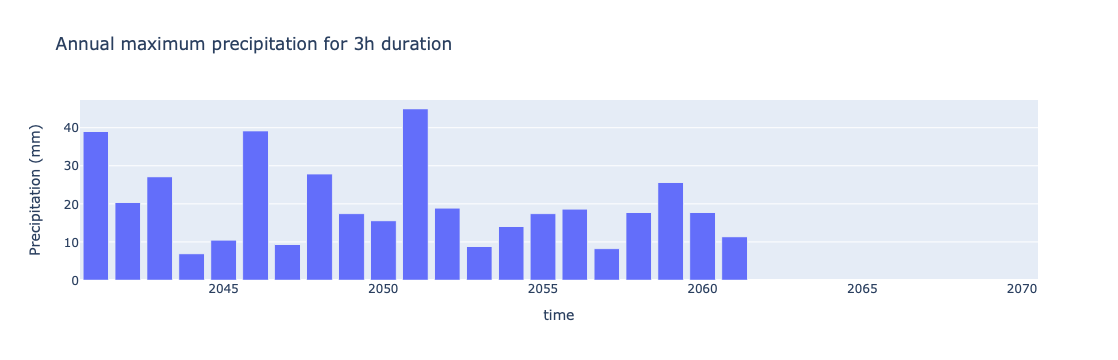

In [184]:
# Define specific spatial coordinates within your selected region and the only available duration
lat = -11
lon = -8
dur = 3
# Selecting a duration and one specific point.
dataarray_pr_max = dataset_pr_max['pr_max'].sel(duration=dur, rlat = lat, rlon = lon, method = 'nearest')
dataset_pr_max.close
# Converting dataarray to dataframe for plotly library to understand.
dataframe_pr_max = dataarray_pr_max.to_dataframe().reset_index()
# Define bar chart and customize it.
figure = px.bar(dataframe_pr_max, x="time", y="pr_max", title=f'Annual maximum precipitation for {dur}h duration')
figure.update_layout(yaxis=dict(title="Precipitation (mm)")) #, range=[10, max(df.precipitation)+5]))
figure.show()

### Step 2. Probability distribution fitting of annual maxima series
The approach consists on trying different probability distributions as to determine which is the one that best represents each pixel's temporal serie of annual maximum precipitation.

Probability distributions are imported from the Python library ```scipy```.

In [158]:
# Function defined to fit a 1D (for one pixel) temporal series.
from scipy.stats import gumbel_r, genextreme, lognorm, pearson3

def distribution_fit(ts_max):
    n = ts_max.size
    # Dict for distribution parameters.
    param = {}
    # Dict for Kolmogorov-Smirnov statistic.
    ks = {}
    
    # Loop over the usual distributions used in hydrology.
    for dist in [gumbel_r, genextreme]:
        # Extract estimated parameters
        param[dist] = dist.fit(ts_max)
        # Goodnes of fit using Kolmogorov-Smirnov test.
        test = sst.ks_1samp(ts_max, dist.cdf, param[dist])
        # KS statistic
        ks[dist] = test[0]
    
    # Choose distribution with minimum Kolmogorov-Smirnov.
    best_fit = min(ks, key=ks.get)
    
    # Check if it's genextreme and the shape parameter makes variance to inf. If so, do fit with other distributions.
    if isinstance(best_fit, genextreme.__class__) and param[genextreme][0] < -0.4:
        # Remove genextreme from the possible distributions.
        param.pop(genextreme)
        ks.pop(genextreme)
        
        # Natural logarithm of the temporal series to use Log-Pearson III.
        data_log = np.log(ts_max)
        
        for i, dist in enumerate([pearson3, lognorm]):
            if isinstance(dist, pearson3.__class__)
                data = data_log
            else:
                data = ts_max
            param[dist] = dist.fit(data)
            test = sst.ks_1samp(data, dist.cdf, param[dist])
            ks[dist] = test[0]

        # Choose the best fitting from the new distributions.    
        best_fit = min(ks, key=ks.get)

    ### Uncomment the next lines to visualize the fitting.
    # distributions = list(param.keys())
    # x = np.linspace(0, np.max(ts_max), 100)
    # fig, ax = plt.subplots(len(param), 3, figsize=(15, 10))
    # for i, dist in enumerate(distributions):
    #     if dist == pearson3:
    #         data = data_log
    #     else:
    #         data = ts_max
    #     res = sst.probplot(data, dist=dist, sparams=param[dist], plot=ax[i, 0])
    #     ax[i, 1].plot(x, dist.cdf(x, *param[dist]))
    #     ax[i, 1].hist(data, density=True, cumulative = True)
    #     ax[i, 2].plot(x, dist.pdf(x, *param[dist]))
    #     ax[i, 2].hist(data, density=True)
    
    # plt.suptitle(f'Plots for {[f.name for f in distributions]}')
    
    # print(f'The distribution selected is {best_fit.name}')
    return best_fit


For example, we can apply this function to the temporal serie of the selected point:

In [120]:
annual_maxima_point = dataarray_pr_max.values
distribution_selected = distribution_fit(annual_maxima_point)

The distribution selected is gumbel_r


### Step 3. Expected intensities for different return periods
Once the probability distribution is selected, the last step is to compute the expected instensities for each duration and return period. Return values and confidence intervals are defined following Chow (Applied Hidrology, 1988).

In [156]:
# Code for intensity value and confidence interval.

def compute_intensity(ts_max, dist_fit):
    # Select distribution (Needed for applying functions to whole region afterwards)
    if not dist_fit:
        dist_fit = distribution_fit(ts_max)
    # Define return years/frequency
    frequencies = np.asarray([2,5,10,25,50,100,200,500])
    n = ts_max.size
    data_log = np.log(ts_max)
    # Values and confidence intervals are defined using a frequency factor that varies with each distribution.
    # Also for genextreme, lognorm or pearson3 it is necessary to work with logarithmic values.
    if isinstance(dist_fit, gumbel_r.__class__):
        data = ts_max
        freq_factor = -np.sqrt(6) / np.pi * (0.5772 + np.log(np.log(frequencies / (frequencies - 1))))
    elif isinstance(dist_fit, genextreme.__class__):
        data = data_log
        freq_factor = -np.sqrt(6) / np.pi * (0.5772 + np.log(np.log(frequencies / (frequencies - 1))))
    elif isinstance(dist_fit, lognorm.__class__):
        data = data_log
        freq_factor = sst.norm.isf(1 / frequencies)
    elif isinstance(dist_fit, pearson3.__class__):
        data = data_log
        # k and z parameters defined at Chow
        k = sst.skew(data)/6
        z = sst.norm.isf(1 / frequencies)
        z2, z3 = np.power(z, 2), np.power(z, 3)
        k_pow = [np.power(k, j) for j in range(1, 6)]
        freq_factor = z + (z2 - 1) * k_pow[0] + (z3 - 6 * z) * k_pow[1] / 3 - (z2 - 1) * k_pow[2] + z * k_pow[3] - k_pow[4] / 3
    else:
        raise Exception("Distribution selected has to be: gumbel_r, genextreme, lognorm or pearson3.")
        
    # Level of confidence at 95%
    normal_level = np.power(1.96, 2)
    a = 1 - normal_level / 2 / (n - 1)
    b = np.power(freq_factor, 2) - normal_level / n

    data_mean = data.mean()
    data_std = data.std()
    freq_factor_upper = freq_factor + np.sqrt(np.power(freq_factor, 2) - a * b)  # falta divide by a
    freq_factor_lower = freq_factor - np.sqrt(np.power(freq_factor, 2) - a * b)
    
    # return value, ci_lower, ci_upper
    return_value = data_mean + freq_factor * data_std
    ci = [return_value, data_mean + data_std * freq_factor_lower / a,
          data_mean + data_std * freq_factor_upper / a]

    if dist_fit != gumbel_r:
        ci = np.exp(ci)

    ## Code to plot the confidence intervals.
    # plt.plot(frequencies, ci[0], frequencies, ci[1], frequencies, ci[2])
    # plt.xlabel('Return periods (years)')
    # plt.ylabel('Expected intensity per duration (mm)')
    # plt.show()
    
    return np.asarray(ci)

Using our example, we can compute the expected intensities and confidence intervals applying this function:

In [183]:
# Uncomment prints and plots in previous cell's to see some output for the next line
compute_intensity(dataarray_pr_max.values, distribution_selected);

### Applying step 2 and 3 to entire region
To do this, the function ```apply_along_axis``` is used to easily repeat the previous process to each pixel of the region - that has been previously selected when computing annual maxima files.

:::{note}
Uncomment previous lines of code reserved to plot graphs and print information to have a cleaner outcome
:::

In [188]:
# Select a duration and open the corresponding .nc file.
dur = 3
dataset_pr_max = xr.open_dataset(os.path.join(data_dir, f'pr_annualMax_{dur}h_2041_2070.nc'),
                                 decode_coords='all')

# Values of variables pr_max as a numpy ndarray.
data = dataset_pr_max['pr_max'].values
# Apply compute_intensity function to every pixel. Return a new ndarray.
idf_values = np.apply_along_axis(compute_intensity, 1, data, dist_fit = '')

# Create a new Dataset with the intensities. Some coordinates are the same as in the original file (lat, lon, duration).
idf_dataset = xr.Dataset(
            data_vars = {'idf' : (['duration', 'ci_level', 'frequency', 'rlat', 'rlon'], idf_values)},
            coords = {'duration': dataset_pr_max.indexes['duration'],
                      'ci_level': ['value', 'lower', 'upper'],
                      'frequency': np.asarray([2,5,10,25,50,100,200,500]),
                      'rlat': dataset_pr_max.indexes['rlat'],
                      'rlon': dataset_pr_max.indexes['rlon']
                      }
            )

# Write CRS 
idf_dataset.rio.write_crs(rotated_pole, inplace=True)

# Save as a netCDF file in the results directory.
idf_dataset.to_netcdf(os.path.join(results_dir, f'idf_{dur}h_2041_2070.nc'))
idf_dataset.close

## Plot the results
Visualize the expected intensity values with a map using the ```matplotlib``` and ```cartopy``` libraries.

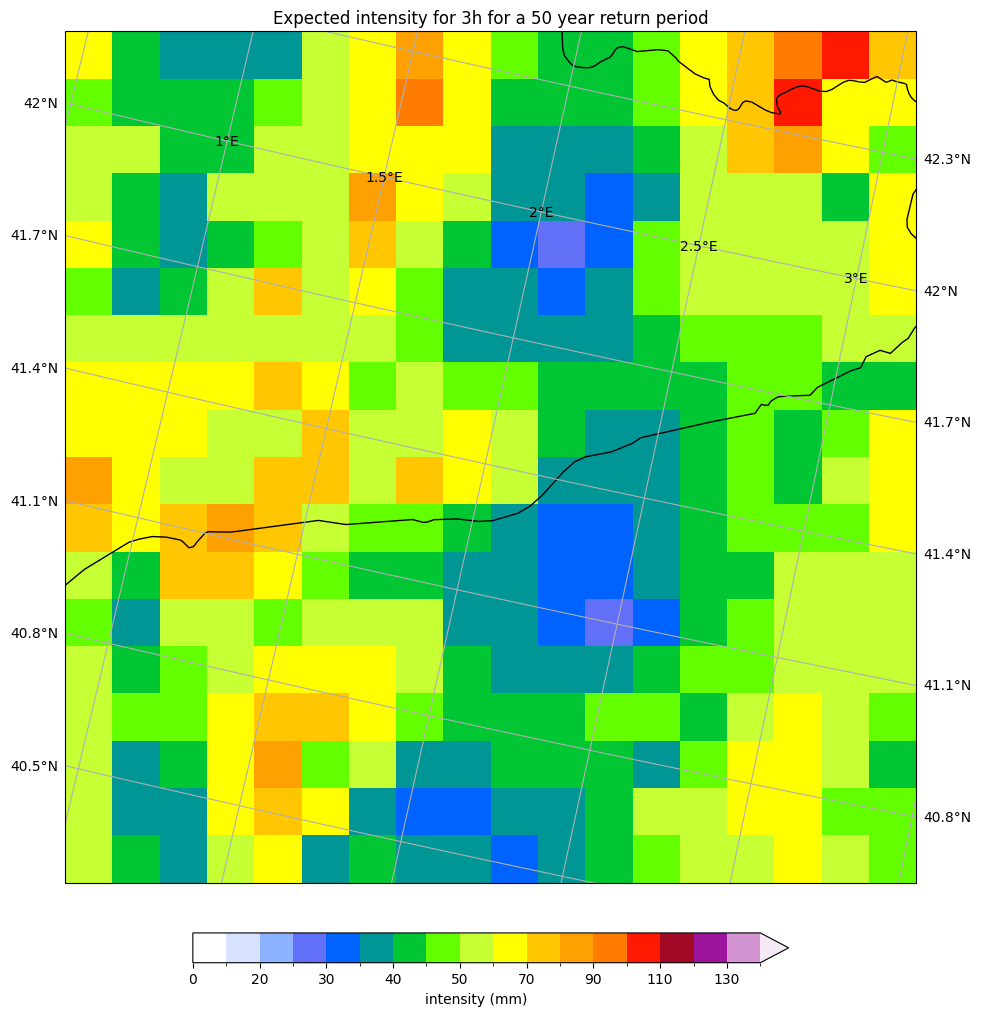

In [9]:
# Select duration and open the correponding .nc file of intensities
dur = 3
idf_dataset = xr.open_dataset(os.path.join(results_dir, f'idf_{dur}h_2041_2070.nc'), decode_coords='all')
crs = ccrs.RotatedPole(pole_latitude=39.25, pole_longitude=-162)

# Select which return period to plot from [2,5,10,25,50,100,200,500]
freq = 50

# Display map with matplotlib and cartopy
fig, ax = plt.subplots(figsize = (12,10), layout="constrained",subplot_kw={'projection': crs})

# Values that delimit colorbar
z_pal = [0., 5., 20, 25, 30, 35, 40, 45, 50, 60., 70., 80, 90., 100., 110, 120., 130, 140]

# Colorbar colors
pal_rgb = ['#ffffff00', '#d6e2ffff', '#8db2ffff', '#626ff7ff', '#0062ffff', '#019696ff', '#01c634ff',
           '#63ff01ff', '#c6ff34ff', '#ffff02ff', '#ffc601ff', '#ffa001ff', '#ff7c00ff', '#ff1901ff', '#a20a28ff',
           '#9b159dff', '#d294d3ff', '#f6e9f6ff']

# Creating matplotlin colormap
cmap, norm = from_levels_and_colors(z_pal, pal_rgb, extend='max')

# Extracting data values
data = idf_dataset['idf'].sel(duration = dur, ci_level = 'value').sel(frequency = freq)

im=ax.pcolormesh(idf_dataset['rlon'], idf_dataset['rlat'], data, norm = norm ,cmap = cmap)

ax.set_title(f'Expected intensity for {dur}h for a {freq} year return period')

# Adding gridlines and features to the map
gridlines = ax.gridlines(draw_labels=True)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS)

fig.canvas.header_visible = False
cbar = fig.colorbar(im, ax=ax, orientation='horizontal',shrink = 0.5)  
cbar.set_label('intensity (mm)')

plt.show()